# Градиентный спуск
## Задача поиска оптимальных коэффициентов полиномиальной модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума ${\epsilon}$:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$.

Определим полиномиальную функцию, в частном и в общем виде:

In [2]:
def f_trend(x):
    return x**3 - 3*x**2 + 2*x - 5

def f_poly(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

Сгенерируем синтетический датасет и построим графики.

<function matplotlib.pyplot.show(close=None, block=None)>

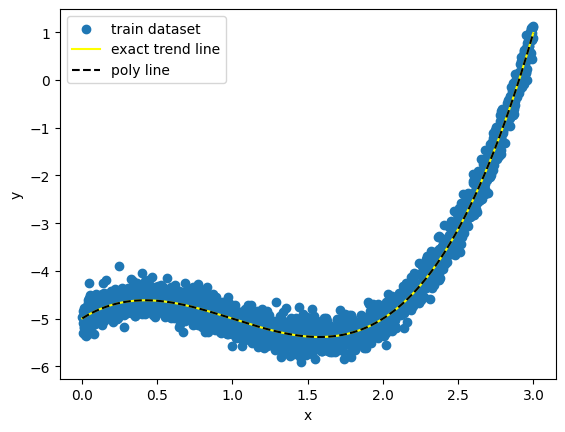

In [ ]:
x_min = 0
x_max = 3
N_points = 2000
# Случайный набор X-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), np.array([[-5, 2, -3, 1]])), '--', color='black')
plt.legend(['train dataset', 'exact trend line', 'poly line'])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/dataset_plot.png')
plt.show

Функция ошибки:

In [4]:
def loss_func(X, y, w_coeff):
    return np.sum((y - f_poly(X, w_coeff))**2)

Функция поиска параметров методом градиентного спуска.

In [ ]:
def model_fit(X_train, y_train, learning_rate, tolerance, batch_ratio, beta):
    t_init = time.time()

    batch_size = int(batch_ratio * len(X_train))
    
    iteration_max = 200000
    # Коэффициенты (веса) инициилизируются нулями.
    w_coeff = np.zeros((1,len(learning_rate)))
    # Буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()
    
    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    # Аккумулятор для фильтра градиента.
    grad_filter = np.zeros_like(grad)
    
    losses = []
    
    for i in range(iteration_max):
        for k, w in enumerate(w_coeff.tolist()[0]):
            # Накопление "момента".
            grad_filter[0,k] = beta * grad_filter[0,k] + (1 - beta) * grad[0,k]
            # Шаг градиентного спуска.
            w_step = - learning_rate[k] * grad_filter[0,k]
            # Сбрасываем коэффициенты до необновленных значений.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Выборка случайных элементов (по индексам).
            batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_train_batch = [X_train[idx] for idx in batch_indices]
            y_train_batch = [y_train[idx] for idx in batch_indices]
            
            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_func(X_train_batch, y_train_batch, w_coeff  ),
                              loss_func(X_train_batch, y_train_batch, w_coeff_1),
                              loss_func(X_train_batch, y_train_batch, w_coeff_2)]
            # Массив градиента состоит из 3х чисел с индексами [0, 1, 2]. Берем предпоследнее число.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление оного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k]
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)
        
        if i % 100 == 0:
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('MSE loss:', np.round(loss,4))
        if (loss < tolerance):
            break
    iter_final = i
    fit_time = time.time() - t_init
    return w_coeff, losses, iter_final, fit_time

В ходе обучения заложим среднеквадратическое отклонение до 0.2. Соответствующая сумма квадратов отклонений: (0.2**2 * N_points)=80.

Сначала попробуем обучение на полном датасете, причем learning rate зададим одинаковыми для каждого искомого параметра модели.

Установлено, что большое значение параметра learning rate приводит к неустойчивости решателя. Функция ошибки "улетает" в бесконечность.

Напротив, при малом значении параметра learning rate оптимизация выполняется медленно.

В результате проб подобрано наибольшее значение learning rate, при котором сходимость устойчива (функция ошибки не "улетает" в бесконечность).

In [ ]:
# Обучение на полном датасете.
# lr - const.
weights_1, losses_1, iter_final_1, fit_time_1 = model_fit(X_train, y_train,
                                                          learning_rate=5*[1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 0
Gradient: [ 16679.6419  21847.6737  38673.1021  76327.7321 160746.5519]
Weights: [-0. -0. -0. -0. -0.]
MSE loss: 39331.2203
Iteration: 100
Gradient: [11810.6595 11213.8093 12224.5503  5366.5725  7195.4937]
Weights: [-0.1232 -0.1219 -0.1401 -0.1316  0.0279]
MSE loss: 28378.6177
Iteration: 200
Gradient: [ 10448.5983  10062.8216  10287.9368   8921.9877 -11249.0956]
Weights: [-0.2341 -0.2257 -0.2552 -0.2252  0.087 ]
MSE loss: 23367.3334
Iteration: 300
Gradient: [  9591.0676   8746.7259   7430.7431   5605.247  -12423.3357]
Weights: [-0.3351 -0.3172 -0.3552 -0.3058  0.1379]
MSE loss: 19499.0244
Iteration: 400
Gradient: [ 8567.5884  7643.7405  7910.8877  6768.7965 -6117.6992]
Weights: [-0.4275 -0.3979 -0.4408 -0.3711  0.1806]
MSE loss: 16552.298
Iteration: 500
Gradient: [ 8182.7437  6814.4186  7539.0731  5061.8238 -2243.0619]
Weights: [-0.5125 -0.4692 -0.5151 -0.4266  0.2181]
MSE loss: 14253.4047
Iteration: 600
Gradient: [ 7483.4197  5871.8188  6150.9166  5043.2291 -1115.1463]
We

В заданное максимальное число итераций не достигнут желаемый уровень ошибки.

Попробуем задать разный learning rate для параметров модели.

In [ ]:
# Обучение на полном датасете.
# lr - индивидуальный для каждого из параметров модели.
weights_2, losses_2, iter_final_2, fit_time_2 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 0
Gradient: [ 16611.1108  21298.1555  38968.8642  74704.4684 164582.5614]
Weights: [-0. -0. -0. -0. -0.]
MSE loss: 39331.0593
Iteration: 100
Gradient: [  1043.4668  -1026.6181  -9024.9074 -31069.6578 -83995.3579]
Weights: [-3.9211 -0.202   0.029   0.0196  0.0073]
MSE loss: 3758.9952
Iteration: 200
Gradient: [   568.3362   -407.9371  -4947.4253 -16714.5811 -61279.9385]
Weights: [-4.6694 -0.1175  0.0861  0.0416  0.0144]
MSE loss: 1724.7838
Iteration: 300
Gradient: [   187.5375     57.2999  -2276.1904  -9578.1586 -34812.8041]
Weights: [-5.0068 -0.1048  0.1137  0.0534  0.0186]
MSE loss: 1191.3328
Iteration: 400
Gradient: [   124.8738     75.7863   -818.9668  -5569.0072 -21498.2604]
Weights: [-5.1503 -0.1235  0.126   0.0606  0.0214]
MSE loss: 1019.0645
Iteration: 500
Gradient: [   -39.3786    439.9886   -416.8938  -3859.3018 -18647.6052]
Weights: [-5.2052 -0.159   0.1309  0.0652  0.0235]
MSE loss: 937.8568
Iteration: 600
Gradient: [   -58.9449    239.5264    -40.2474  -5522.5207 

В заданное максимальное число итераций также не достигнут желаемый уровень ошибки. Но скорость сходимости улучшилась значительно.

Попробуем обучать не на полном датасете, а на случайно выбранных значениях.

В таком случае оказалось, что обучение на батчах устойчиво при бОльших значениях learning rate. Получается, разбиение на батчи не только снижает объем вычислений, но и позволяет улучшить сходимость за счет большего learning rate.

In [ ]:
# Обучение на случайных батчак, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
weights_3, losses_3, iter_final_3, fit_time_3 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.0)

Iteration: 0
Gradient: [ 1722.7644  2196.2994  3867.5832  7571.7992 14229.5169]
Weights: [-0.001  -0.0001 -0.     -0.     -0.    ]
MSE loss: 39312.0109
Iteration: 100
Gradient: [   -1.8276    24.9851    23.6876  -761.9254 -1649.0665]
Weights: [-5.0723 -0.432   0.1535  0.078   0.0297]
MSE loss: 701.1158
Iteration: 200
Gradient: [   9.1634  -14.4461   80.4348 -150.9966  -59.0444]
Weights: [-4.8031 -0.7214  0.1299  0.0936  0.038 ]
MSE loss: 478.0744
Iteration: 300
Gradient: [  -8.5658   45.9752   54.3001 -139.3846 -203.7154]
Weights: [-4.66   -0.8985  0.0998  0.1062  0.0441]
MSE loss: 365.4998
Iteration: 400
Gradient: [  11.4396   20.0832  108.2621  141.2623 -954.0145]
Weights: [-4.4979 -1.0547  0.0887  0.1151  0.0487]
MSE loss: 297.0236
Iteration: 500
Gradient: [  6.8643  34.5816 -57.0694  45.4597  39.1937]
Weights: [-4.3603 -1.1645  0.0691  0.123   0.0523]
MSE loss: 259.6127
Iteration: 600
Gradient: [  -6.4478   -7.098    67.5645   25.3931 -373.2218]
Weights: [-4.3036 -1.2407  0.0539  0

Теперь добавим фильтр градиента (momentum) по правилу:

${G_n = \beta G_{n-1} + (1 - \beta)grad_n}$,

${\beta \neq 0}$.

In [ ]:
# Обучение на случайных батчак, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
# Фильтрация градиента (beta=0.8).
weights_4, losses_4, iter_final_4, fit_time_4 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.8)

Iteration: 0
Gradient: [ 1653.8697  2208.3991  3991.4472  8502.208  15523.765 ]
Weights: [-0.0002 -0.     -0.     -0.     -0.    ]
MSE loss: 39327.4031
Iteration: 100
Gradient: [   -4.2848   -39.7197   -56.1211  -292.5246 -1658.0983]
Weights: [-5.1164 -0.3682  0.1336  0.0748  0.0307]
MSE loss: 719.4727
Iteration: 200
Gradient: [  14.3254   65.2956   86.9634 -621.0712  200.0639]
Weights: [-4.8299 -0.6496  0.1016  0.0894  0.0408]
MSE loss: 477.3759
Iteration: 300
Gradient: [  16.1042  -17.8151   13.7967 -110.1817 -924.2089]
Weights: [-4.6185 -0.8768  0.0856  0.0968  0.048 ]
MSE loss: 349.1848
Iteration: 400
Gradient: [-20.5589  60.2301 -66.8076 -45.8473 129.61  ]
Weights: [-4.4938 -1.0242  0.0709  0.1038  0.0534]
MSE loss: 283.1345
Iteration: 500
Gradient: [   6.8061   19.129    15.2614   20.268  -462.8656]
Weights: [-4.4271 -1.0956  0.0561  0.107   0.0573]
MSE loss: 252.8433
Iteration: 600
Gradient: [ -14.0985   14.5096   11.1932  -50.3558 -166.5598]
Weights: [-4.347  -1.1598  0.0402  0

In [ ]:
weights_5, losses_5, iter_final_5, fit_time_5 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.4)

Iteration: 0
Gradient: [ 1661.8269  1940.6748  3944.2258  7347.65   16442.8078]
Weights: [-0.0006 -0.0001 -0.     -0.     -0.    ]
MSE loss: 39319.7065
Iteration: 100
Gradient: [  -16.8079    64.7484   -16.3544  -708.4154 -1386.9012]
Weights: [-5.0835 -0.4052  0.1263  0.0777  0.0321]
MSE loss: 680.4919
Iteration: 200
Gradient: [  -8.9434   28.0478  102.5649 -233.1932 -188.3906]
Weights: [-4.8072 -0.7005  0.1002  0.092   0.0416]
MSE loss: 451.2732
Iteration: 300
Gradient: [    3.6288   -26.344     31.7973  -280.5392 -1045.9457]
Weights: [-4.6272 -0.9039  0.0814  0.1036  0.048 ]
MSE loss: 337.5957
Iteration: 400
Gradient: [ -12.5757    3.2383   29.8561   31.0318 -457.7536]
Weights: [-4.4762 -1.0403  0.0578  0.1109  0.0528]
MSE loss: 276.9013
Iteration: 500
Gradient: [   5.8685   -5.4504   50.5289    0.7166 -282.038 ]
Weights: [-4.3788 -1.1381  0.0432  0.1159  0.0568]
MSE loss: 243.4831
Iteration: 600
Gradient: [  17.6008   29.8737   -1.1829  -51.5116 -183.6645]
Weights: [-4.2858 -1.1994 

In [ ]:
weights_6, losses_6, iter_final_6, fit_time_6 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.2,
                                                          beta=0.2)

Iteration: 0
Gradient: [ 3232.2956  4402.7926  7785.6578 14794.7759 31771.3655]
Weights: [-0.001  -0.0001 -0.     -0.     -0.    ]
MSE loss: 39312.0109
Iteration: 100
Gradient: [    1.5996    96.822    208.9188    50.2622 -1066.8014]
Weights: [-4.7695 -0.7066  0.0923  0.0955  0.0412]
MSE loss: 444.9471
Iteration: 200
Gradient: [   4.0082   38.1315   66.1652  -51.1935 -493.5062]
Weights: [-4.4873 -1.0499  0.0625  0.1105  0.0531]
MSE loss: 275.868
Iteration: 300
Gradient: [  16.8264   30.9993   18.0861   -8.2613 -926.9618]
Weights: [-4.3165 -1.2138  0.0401  0.1191  0.059 ]
MSE loss: 229.0924
Iteration: 400
Gradient: [ 17.5154  47.3809  73.6792 205.2618 111.4398]
Weights: [-4.2316 -1.282   0.0189  0.1207  0.0635]
MSE loss: 212.2709
Iteration: 500
Gradient: [ -13.5381  -46.208    -1.6095  -45.3356 -286.0314]
Weights: [-4.1832e+00 -1.3190e+00 -1.0000e-04  1.2300e-01  6.6700e-02]
MSE loss: 204.8232
Iteration: 600
Gradient: [  15.516   -18.9261   10.9645 -104.1766 -590.7582]
Weights: [-4.163 

<function matplotlib.pyplot.show(close=None, block=None)>

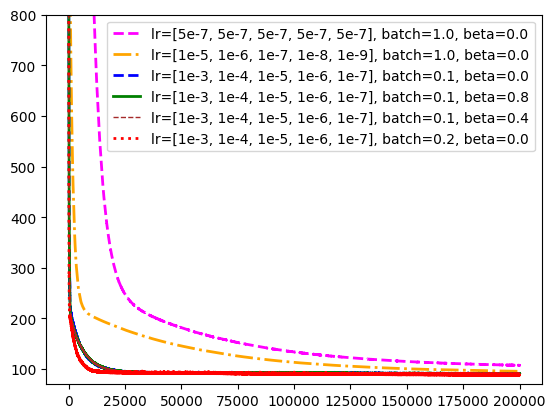

In [62]:
plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_4, color='green', linestyle='-', linewidth=2)
plt.plot(losses_5, color='brown', linestyle='--', linewidth=1)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,800)

plt.legend(['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
            'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.8',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.4',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0'])
plt.show

Кривые для batch=0.1, beta=[0.0, 0.4, 0.8] практически накладываются друг на друга. Следовательно, в рассмотренной частной задачи оптимизации параметр beta незначим. Фильтрация градиента (Momentum) не требуется.

<function matplotlib.pyplot.show(close=None, block=None)>

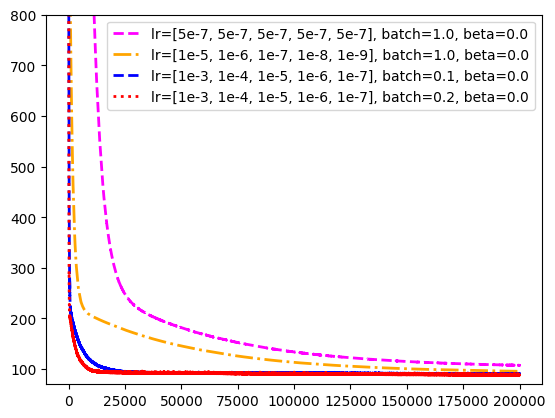

In [63]:
legend_list =  ['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
                'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0']

plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,800)
plt.legend(legend_list)
plt.savefig('plots/MSE_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

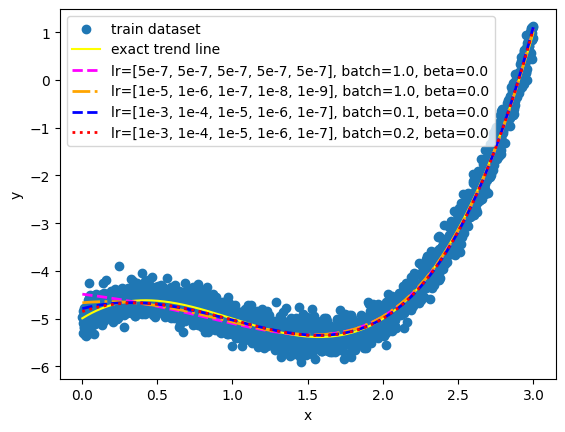

In [59]:
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_1), color='magenta', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_2), color='orange', linestyle='-.', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_3), color='blue', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_6), color='red', linestyle=':', linewidth=2)
plt.legend(['train dataset', 'exact trend line'] + legend_list)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/trend_line_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

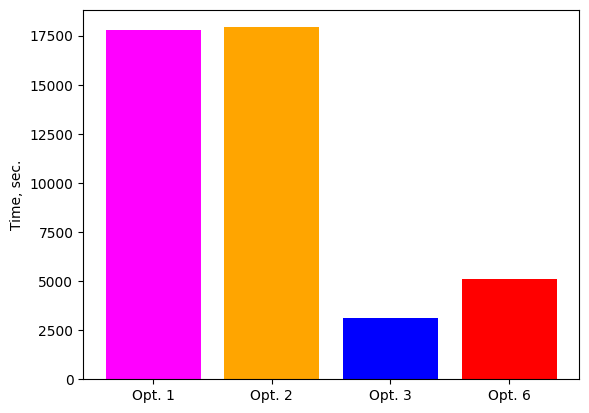

In [56]:
fit_time = [fit_time_1, fit_time_2, fit_time_3, fit_time_6]
bar_label = ['Opt. 1', 'Opt. 2', 'Opt. 3', 'Opt. 6']
bar_colors = ['magenta', 'orange', 'blue', 'red']
plt.bar(bar_label, fit_time, color=bar_colors)
plt.ylabel('Time, sec.')
plt.savefig('plots/time_plot.png')
plt.show

In [64]:
#fit_time = [17800.521367788315, 17925.368300437927, 3114.852860212326, 5091.532459259033]
fit_time

[17800.521367788315, 17925.368300437927, 3114.852860212326, 5091.532459259033]